In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from CallOption import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 8192  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10 ** 3
lr = 1e-3

In [4]:
model.load_model("models/CallOption2.pth")

In [5]:
graph = model.iteration, model.training_loss

In [6]:
np.random.seed(42)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

In [7]:
from scipy.stats import multivariate_normal as normal

In [8]:
X_preds = X_pred.reshape(8192,51)

In [9]:
Y_preds = Y_pred.reshape(8192,51)

In [10]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * normal.cdf(d1)) - (K * np.exp(-r * T) * normal.cdf(d2))
    return call_price

def calculate_option_prices(X_pred, time_array, K, r, sigma, T, q=0):
    rows, cols = X_pred.shape
    option_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            if time_to_maturity > 0: 
                option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)
            else:
                option_prices[i, j] = max(S - K, 0) 
    
    return option_prices


# Given parameters
K = 1      # Strike price
r = 0.05   # Risk-free interest rate
sigma = 0.4  # Volatility
q = 0      # Dividend yield (assuming none)
T = 1      # Expiry time in years

Y_test = calculate_option_prices(X_preds, t_test[0], K, r, sigma, T, q)

/tmp/ipykernel_2212220/1573490689.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)


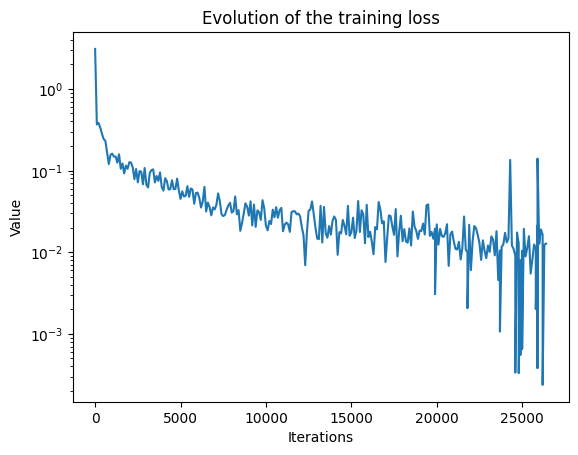

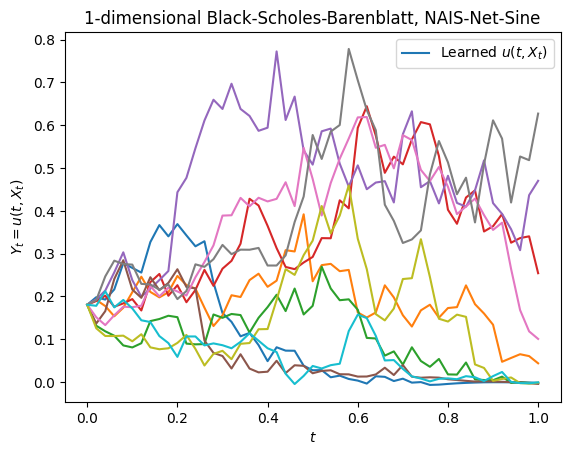

In [11]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 10
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

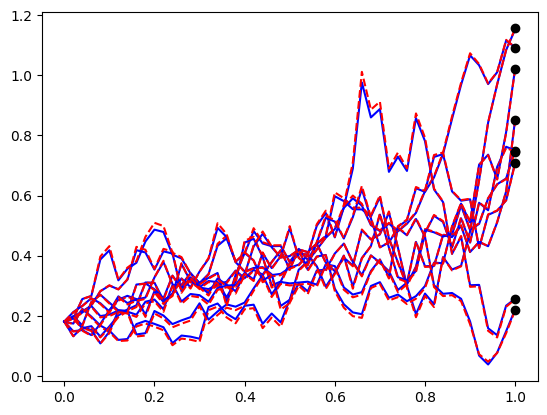

In [20]:
for i in range(samples):
    plt.plot(t_test[i], Y_preds[i], 'b', label='Learned $u(t,X_t)$')
    plt.plot(t_test[i], Y_test[i], 'r--', label='Exact $u(t,X_t)$')
    plt.plot(t_test[i, -1], Y_test[i, -1], 'ko', label='$Y_T = u(T,X_T)$')
plt.show()

In [16]:
errors = (Y_test - Y_preds) ** 2
errors.mean()

0.00020224030511438475

In [18]:
Y_pred.shape

(8192, 51, 1)

In [19]:
r = 0.05

In [20]:
Y_preds = Y_pred.reshape(8192,51)

In [21]:
time_stamps = t_test[0].reshape(51,)
time_stamps

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32)

In [23]:
epe = np.mean(np.exp(-r*time_stamps) * np.maximum(Y_preds,0),axis=0)    
epe

array([0.1807757 , 0.18029933, 0.1807792 , 0.18140051, 0.18168831,
       0.18164706, 0.18240456, 0.1822013 , 0.18184087, 0.18221597,
       0.18306954, 0.18305746, 0.1835272 , 0.18371128, 0.18353455,
       0.18360902, 0.1833729 , 0.18381053, 0.18313096, 0.1836582 ,
       0.1842277 , 0.18380521, 0.18319583, 0.18310256, 0.18243645,
       0.18255283, 0.18175326, 0.18173657, 0.18205352, 0.18117063,
       0.18221875, 0.18208146, 0.18217602, 0.18158221, 0.18116222,
       0.18085651, 0.18063128, 0.179692  , 0.17975667, 0.17947195,
       0.17907749, 0.17860647, 0.178619  , 0.17884287, 0.17909725,
       0.17990185, 0.180739  , 0.18066767, 0.18112445, 0.18204497,
       0.18277062], dtype=float32)

In [24]:
ene = np.mean(np.minimum(Y_preds,0),axis=0)
ene

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -6.6338407e-07,
       -3.2407406e-06, -1.7873130e-05, -4.5994009e-05, -8.3186169e-05,
       -1.4411306e-04, -2.5983070e-04, -3.4537993e-04, -4.5490882e-04,
       -6.4321468e-04, -8.3037611e-04, -1.0283458e-03, -1.3171082e-03,
       -1.6176978e-03, -1.9272475e-03, -2.1680887e-03, -2.4132249e-03,
       -2.6288324e-03, -2.8560883e-03, -2.9773309e-03, -3.1587086e-03,
       -3.3634331e-03, -3.4801087e-03, -3.4922482e-03, -3.4367109e-03,
       -3.3703288e-03, -3.2421199e-03, -3.0375454e-03, -2.8255549e-03,
       -2.6336857e-03, -2.4328106e-03, -2.2079155e-03, -1.9575981e-03,
       -1.6998675e-03, -1.4505148e-03, -1.1922707e-03, -9.5409428e-04,
       -7.4177911e-04, -5.5123906e-04, -3.8538038e-04, -2.4692810e-04,
       -1.4007909e-04, -6.5114538e-05, -6.0346829e-05, -1.4623065e-04,
       -2.8243416e-04, -4.6171222e-04, -6.6255301e-04], dtype=float32)

In [25]:
s=1 # spot price
k=1 # strike price
r=0.05 # risk-free rate
sigma=0.4 # volatility
T=1 # time to maturity

d1 = (np.log(s/k) + (r + 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))
d2 = (np.log(s/k) + (r - 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))

call = (s * normal.cdf(d1, 0.0, 1.0) - k * np.exp(-r * (T - 0) ) * normal.cdf(d2, 0.0, 1.0))

In [26]:
call

0.18022951450216668

In [27]:
epe_exact = np.array([call for s in time_stamps[1:]])
ene_exact = np.array([0.0 for s in time_stamps[1:]])

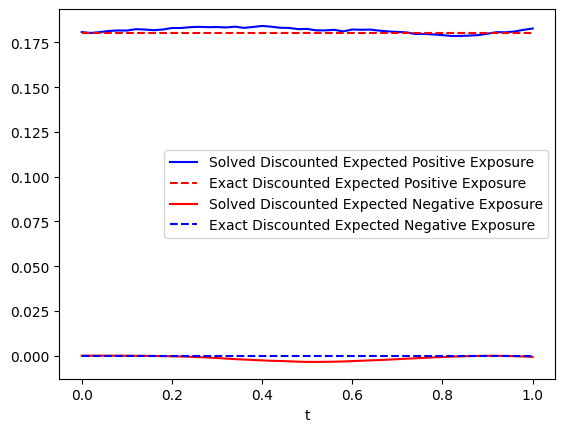

In [28]:
fig = plt.figure()
plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )
plt.plot(time_stamps,[call] + list(epe_exact),'r--',label='Exact Discounted Expected Positive Exposure')
plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')
plt.plot(time_stamps,[0.0]+list(ene_exact),'b--',label='Exact Discounted Expected Negative Exposure')

plt.xlabel('t')
plt.legend()

plt.show()

In [7]:
model.save_model("models/CallOption2.pth")